<a href="https://colab.research.google.com/github/faizanahemad/eva/blob/master/assignment-14/DavidNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**List of Changes**

- Apply OLR


In [1]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm
import gc
import tensorflow as tf


import matplotlib.pyplot as plt
% matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(tf.__version__)

1.14.0


In [0]:
# tf.enable_eager_execution()


In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / (math.sqrt(fan) + np.random.rand()*0.1)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

In [13]:
print(gc.collect())
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

def lr_schedule(t):
  if t<=EPOCHS-2:
    lr = np.interp([t], [0, (EPOCHS+1)//5, EPOCHS-1], [0.0001, LEARNING_RATE, 0.0001])[0]
  else:
    lr = np.interp([t], [ EPOCHS-1, EPOCHS], [0.0001, 0.00001])[0]
  
  return lr


lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0.001, LEARNING_RATE, 0.0001])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)


opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

124


AttributeError: ignored

98 24


<Figure size 576x432 with 0 Axes>

Text(0.5, 1.0, 'Min LR = 0.00000, Max LR = 0.40000, Min Tail LR = 0.00000')

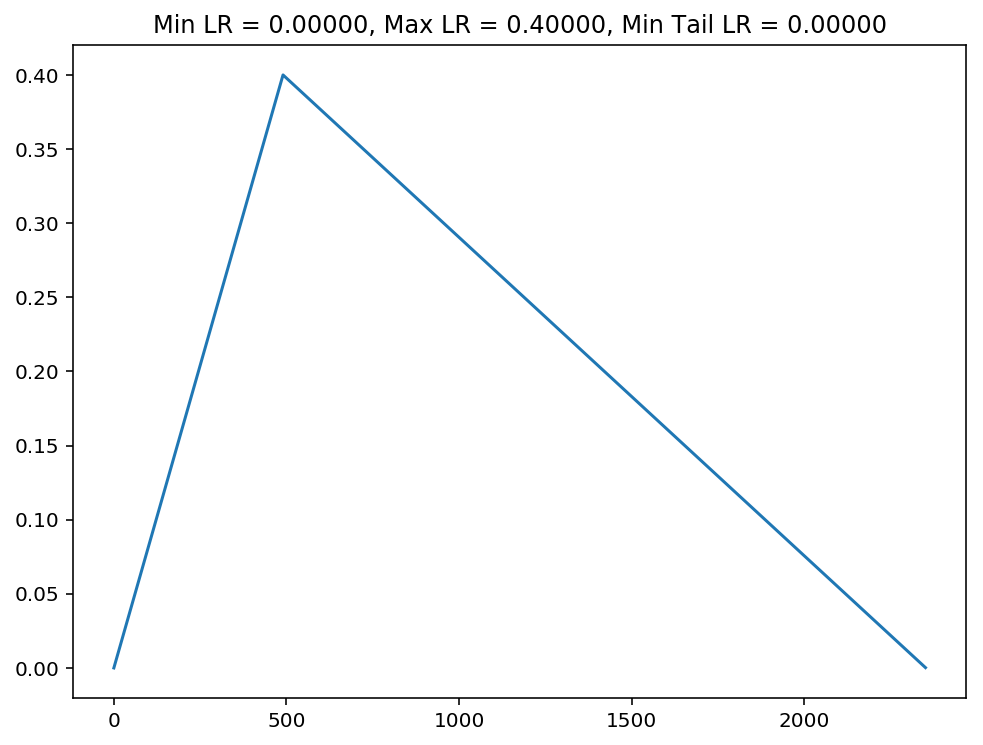

In [10]:
print(batches_per_epoch, EPOCHS)

lrs = []
for i in range(batches_per_epoch*EPOCHS):
  lrs.append(lr_schedule(i/batches_per_epoch))

plt.figure(figsize=(8,6))
plt.plot(lrs)
plt.title("Min LR = %.5f, Max LR = %.5f, Min Tail LR = %.5f"%(np.min(lrs[:len(lrs)//2]),np.max(lrs),np.min(lrs)))
plt.show()


In [11]:
t = time.time()
t_last = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in train_set:
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
  t2 = time.time()
  epoch_time = t2 - t_last
  t_last = t2
    
  print('epoch:', epoch+1, 'lr: %.4f' % (lr_schedule(epoch+1)), '| train loss: %.4f' %(train_loss / len_train), 'train acc: %.3f' % (train_acc / len_train), 'val loss: %.4f' % (test_loss / len_test), 'val acc: %.3f' %(test_acc / len_test),"epoch time: %.2f"%(epoch_time), 'time: %.2f'%(t2 - t))
  
  # 92.79

epoch: 1 lr: 0.0800 | train loss: 5819501190663642.0000 train acc: 0.106 val loss: 1019141813449418.3750 val acc: 0.100 epoch time: 75.80 time: 75.80
epoch: 2 lr: 0.1600 | train loss: 12804036206555714.0000 train acc: 0.100 val loss: 1697275404123688.2500 val acc: 0.100 epoch time: 63.25 time: 139.05
epoch: 3 lr: 0.2400 | train loss: 2.3026 train acc: 0.100 val loss: 1697664438825386.0000 val acc: 0.100 epoch time: 63.40 time: 202.45
epoch: 4 lr: 0.3200 | train loss: 2.3026 train acc: 0.100 val loss: 1702893606175925.7500 val acc: 0.100 epoch time: 63.03 time: 265.49
epoch: 5 lr: 0.4000 | train loss: 2.3026 train acc: 0.100 val loss: 86667011524471344.0000 val acc: 0.100 epoch time: 63.25 time: 328.73
epoch: 6 lr: 0.3789 | train loss: 2.3026 train acc: 0.100 val loss: 16992710490641829888.0000 val acc: 0.100 epoch time: 63.14 time: 391.87
epoch: 7 lr: 0.3579 | train loss: 2.3026 train acc: 0.100 val loss: 2970449546489502367744.0000 val acc: 0.100 epoch time: 63.04 time: 454.91
epoch: 

KeyboardInterrupt: ignored

In [0]:
# Dropout
# OneCycleLR
# Cutout


# Big ideas
# Use Resnet with a highway network like mode with weights for residual, Penalize the weight for residual for its distance from 1.
# Instead of L2 penalization of kernel weights use a Penalization which treats distance from 1/fan-in of weights.